# Part 1: Feature Engineering

This notebook showcases different techniques for feature engineering and how they perform with the baseline model.

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging


logging.getLogger('fgclassifier').setLevel(logging.INFO)

First, check how word segmentation works with the library we chose:

In [2]:
import jieba
from config import validate_data_path, train_data_path
from fgclassifier import read_csv

df = read_csv(validate_data_path, seg_words=False)

print(df['content'][0])
segs = jieba.lcut(df['content'][0])
print(" ".join(segs))

2018-11-08 12:43:32,007 [INFO] Reading data/validate/sentiment_analysis_validationset.csv..
2018-11-08 12:43:32,274 [INFO] Pick a sample of 100


"哎，想当年来佘山的时候，啥都没有，三品香算镇上最大看起来最像样的饭店了。菜品多，有点太多，感觉啥都有，杂都不足以形容。随便点些，居然口味什么的都好还可以，价钱自然是便宜当震惊。元宝虾和椒盐九肚鱼都不错吃。不过近来几次么，味道明显没以前好了。冷餐里面一个凉拌海带丝还可以，酸酸甜甜的。镇上也有了些别的大点的饭店，所以不是每次必来了。对了，这家的生意一如既往的超级好，不定位基本吃不到。不过佘山这边的人吃晚饭很早的，所以稍微晚点去就很空了。"
" 哎 ， 想当年 来 佘山 的 时候 ， 啥 都 没有 ， 三品 香算 镇上 最大 看起来 最 像样 的 饭店 了 。 菜品 多 ， 有点 太 多 ， 感觉 啥 都 有 ， 杂都 不足以 形容 。 随便 点些 ， 居然 口味 什么 的 都 好 还 可以 ， 价钱 自然 是 便宜 当 震惊 。 元宝 虾 和 椒盐 九肚鱼 都 不错 吃 。 不过 近来 几次 么 ， 味道 明显 没 以前 好 了 。 冷餐 里面 一个 凉拌 海带丝 还 可以 ， 酸酸甜甜 的 。 镇上 也 有 了 些 别的 大点 的 饭店 ， 所以 不是 每次 必来 了 。 对 了 ， 这家 的 生意 一如既往 的 超级 好 ， 不 定位 基本 吃 不到 。 不过 佘山 这边 的 人 吃晚饭 很早 的 ， 所以 稍微 晚点 去 就 很 空 了 。 "


In [3]:
# Replace blank space with some materialized words
jieba.add_word('BBLANKK')
jieba.lcut("我，来到北京  清华大学".replace(' ', 'BBLANKK'))

['我', '，', '来到', '北京', 'BBLANKK', 'BBLANKK', '清华大学']

In [4]:
df.iloc[0,:]

id                                                                                          0
content                                     "哎，想当年来佘山的时候，啥都没有，三品香算镇上最大看起来最像样的饭店了。菜品多，有点太多，...
location_traffic_convenience                                                               -2
location_distance_from_business_district                                                   -2
location_easy_to_find                                                                      -2
service_wait_time                                                                           0
service_waiters_attitude                                                                   -2
service_parking_convenience                                                                -2
service_serving_speed                                                                      -2
price_level                                                                                 1
price_cost_effective                                        

## Basic Statistics

First, check how many records we have. As word segmentation takes a while, we read the raw data first.

In [7]:
from config import validate_data_path, train_data_path, test_data_path

# Without segmentation, this is faster
df_train = read_csv(train_data_path, seg_words=False, sample_n=None)
df_validate = read_csv(validate_data_path, seg_words=False, sample_n=None)
print("Training data:", df_train.shape)
print("Validation data:", df_validate.shape)

2018-11-08 12:44:30,473 [INFO] Reading data/train/sentiment_analysis_trainingset.csv..
2018-11-08 12:44:31,951 [INFO] Reading data/validate/sentiment_analysis_validationset.csv..


Training data: (105000, 22)
Validation data: (15000, 22)


In [8]:
df_test = read_csv(test_data_path, seg_words=False, sample_n=None)
print("Test data:", df_test.shape)

2018-11-08 12:44:32,207 [INFO] Reading data/test-a/sentiment_analysis_testa.csv..


Test data: (15000, 22)


Then let's check after segmentation, what does the data look like.

In [9]:
df_train_full = read_csv(train_data_path, seg_words=True, sample_n=None)
df_validate_full = read_csv(validate_data_path, seg_words=True, sample_n=None)
print("Training data:", df_train.shape)
print("Validation data:", df_validate.shape)

2018-11-08 12:44:32,484 [INFO] Reading data/train/sentiment_analysis_trainingset.csv..
2018-11-08 12:44:32,487 [INFO] Found cache, use cached.
2018-11-08 12:44:36,366 [INFO] Reading data/validate/sentiment_analysis_validationset.csv..
2018-11-08 12:44:36,368 [INFO] Found cache, use cached.


Training data: (105000, 22)
Validation data: (15000, 22)


In [10]:
from collections import Counter

def count_words(content, counter=None):
    counts = counter or Counter()
    sentences = []
    for s in content:
        ss = s.split(' ')
        sentences.append(ss)
        counts.update(ss)
    return counts, sentences

count_train, sentences = count_words(df_train_full['content'])
print(count_train.most_common()[:10])

[('，', 2308790), ('的', 1192089), ('。', 690652), ('BBLANKK', 572576), ('了', 511820), ('\n', 396569), ('是', 333631), ('很', 290114), ('吃', 243363), ('也', 222598)]


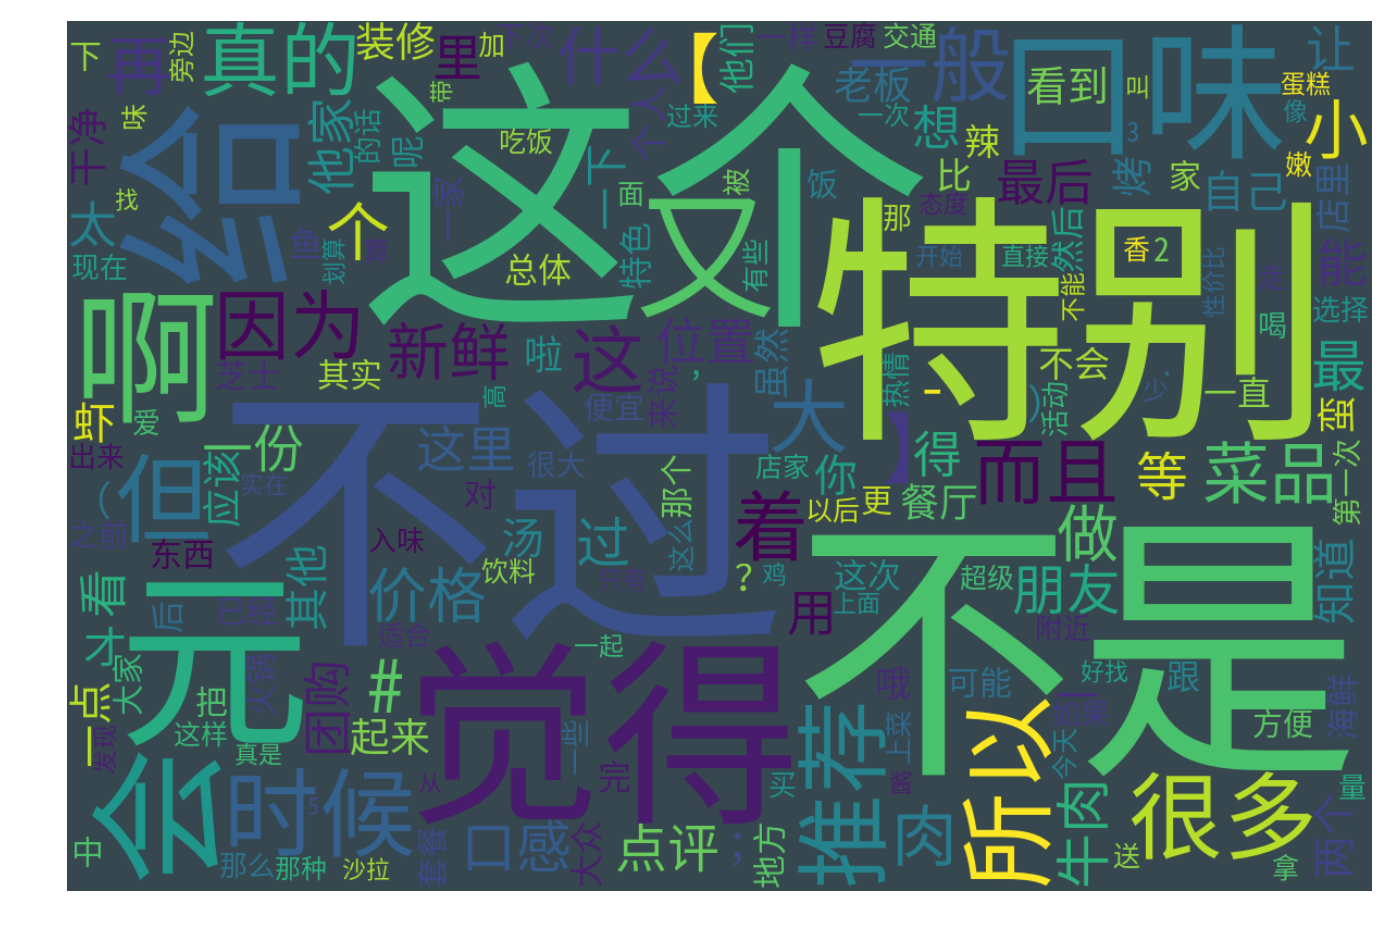

In [11]:
from wordcloud import WordCloud

font = '/Users/jesse/Downloads/SourceHanSansHWSC/SourceHanSansHWSC-Regular.otf'
wordcloud = WordCloud(
    font_path=font, width=1200, height=800,
    background_color='rgb(55, 71, 79)',
).generate_from_frequencies(dict(count_train.most_common()[60:5000]))

plt.figure(figsize=(12, 8))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
print(np.mean([len(s) for s in sentences]))

225.0460541213768


In [6]:
print('Vocabulary size: {}'.format(len(count_train)))

NameError: name 'count_train' is not defined

In [37]:
import pandas as pd

df = pd.DataFrame({ 'values': list(count_train.values()) })
df.describe()

,values
count,2.260080e+05
mean,1.057390e+02
std,6.247931e+03
min,1.000000e+00
25%,1.000000e+00
50%,2.000000e+00
75%,5.000000e+00
max,2.313637e+06


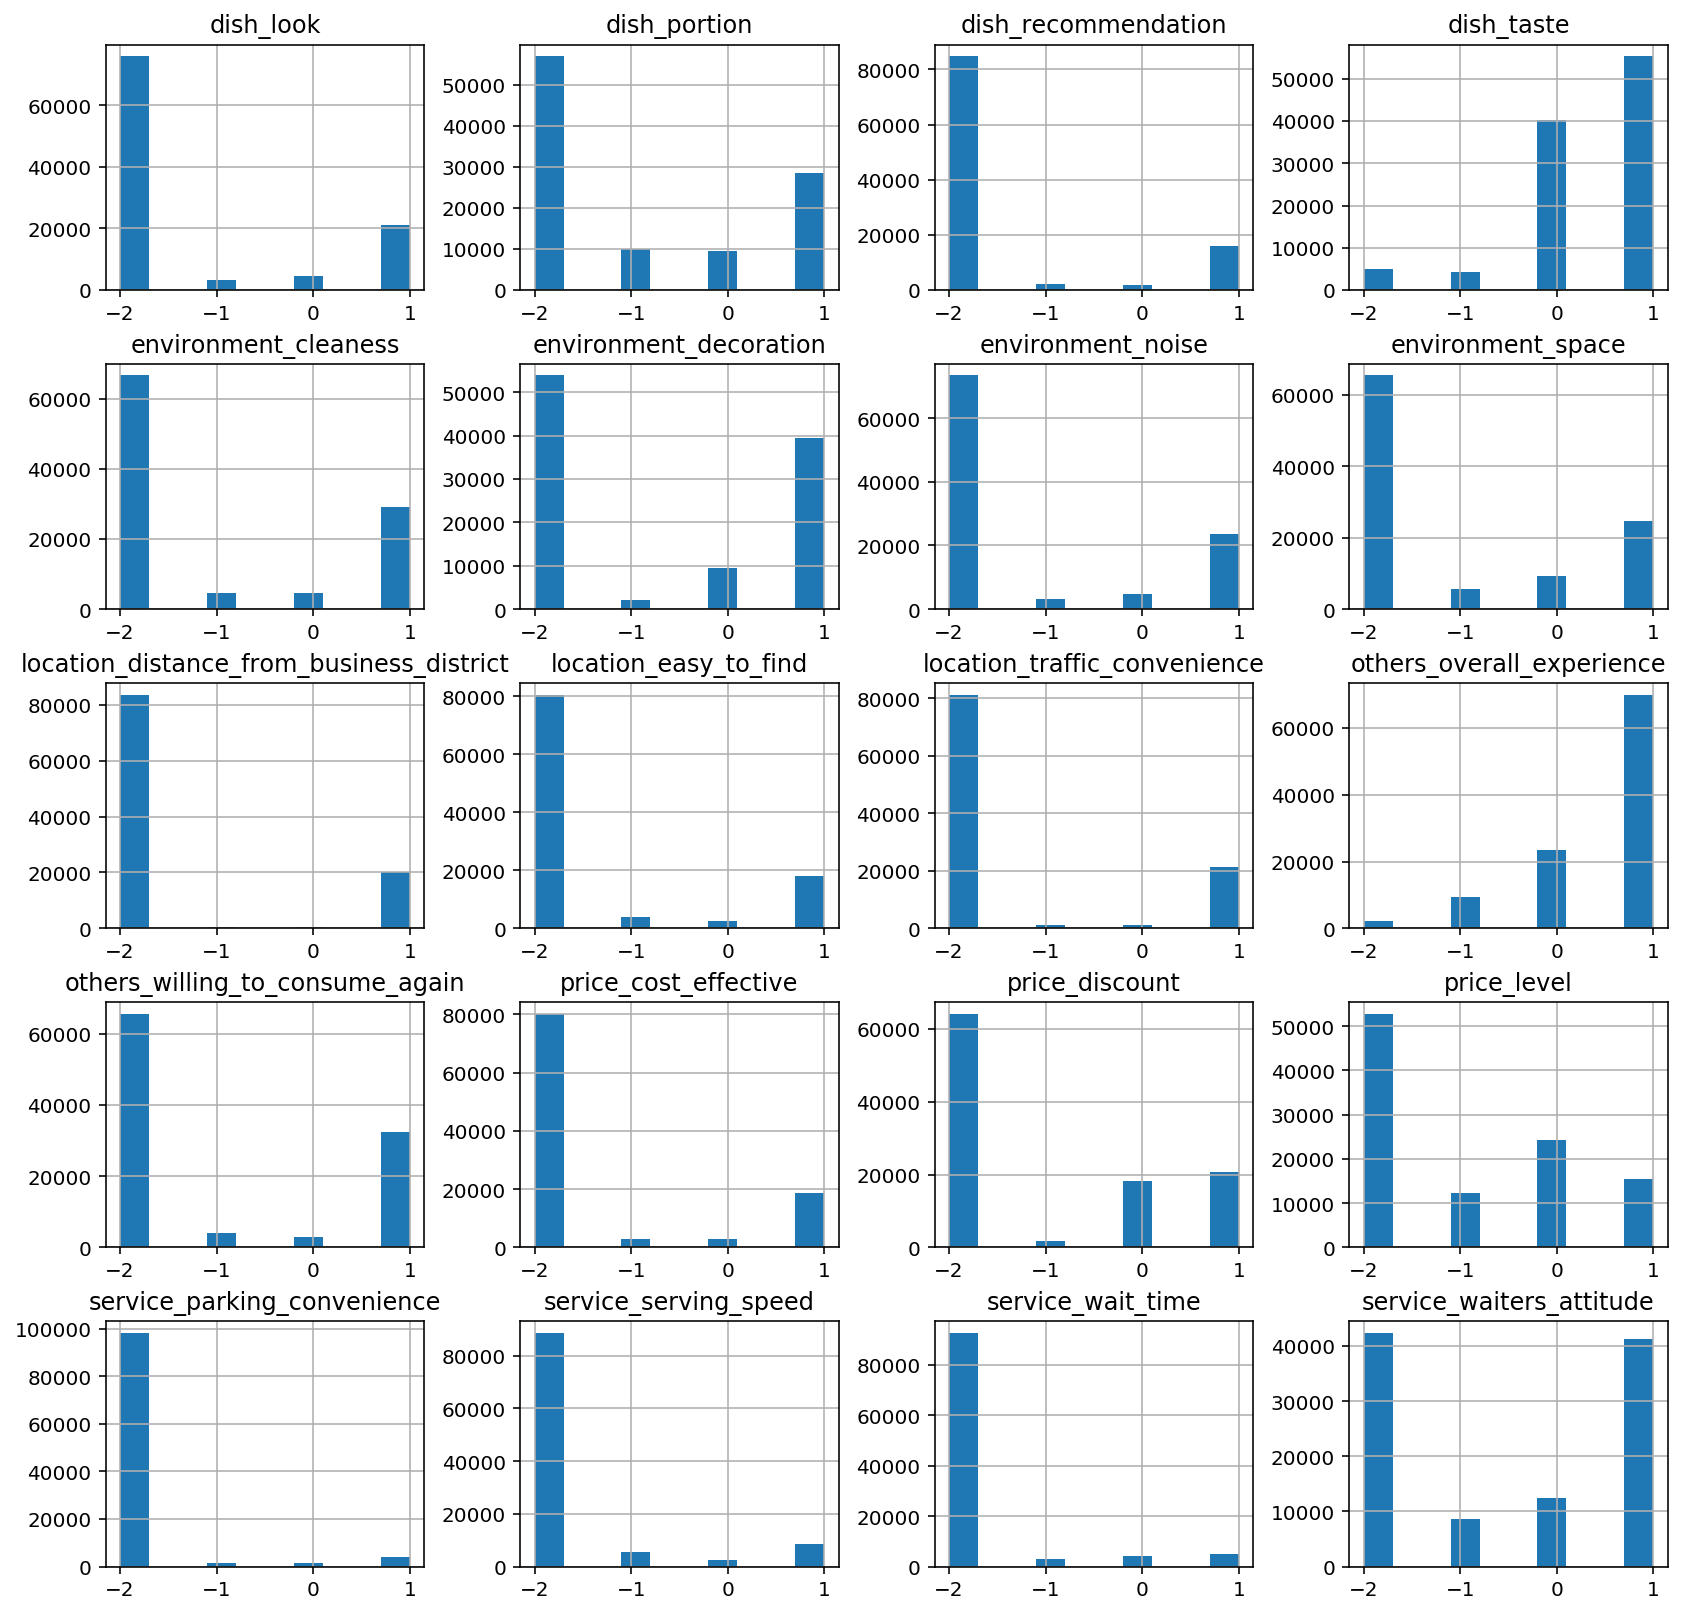

In [15]:
df_train.drop(['id', 'content'], axis=1).hist(figsize=(14, 14))
plt.show()

### Overall Distribution

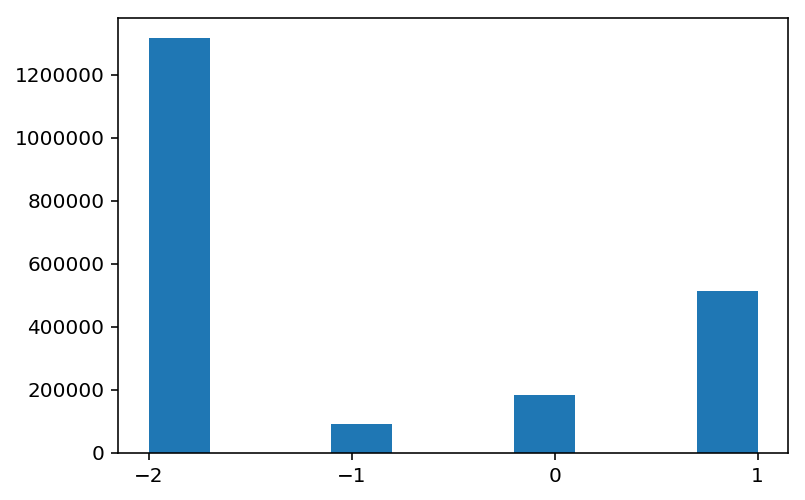

In [21]:
x = df_train.drop(['id', 'content'], axis=1).values.ravel()
plt.hist(x)
plt.xticks([-2, -1, 0, 1])
plt.show()

In [ ]:
import config
from fgclassifier.baseline import Indie

model = Indie()
X_train, Y_train = model.load(config.train_data_path, sample_n=1000)

In [ ]:
Y_train.hist(figsize=(16, 12))
plt.show()

In [ ]:
!python ./fgclassifier/train.py -c MultinomialNB